In [71]:
from typing import Annotated  #hypotetical metadat type 
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages #it reducer-> adds/appends messages to the list instead of replacing them


In [72]:
class State(TypedDict):         #typeddi used for taking value in dictory format
     messages:Annotated[list,add_messages]


In [73]:
graph_builder

In [74]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [75]:
from langchain.chat_models import init_chat_model
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-20b")


In [76]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C57B322900>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C57B325E50>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [77]:
#Node funcitonaluty 
def chatbot(state:State):
  return {"messages":[llm.invoke(state["messages"])]}  #the msg variblae is same as we declar in the class State 

In [78]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot",chatbot)

graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

#compiling thr graph 
graph = graph_builder.compile()

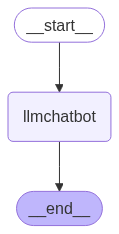

In [79]:
#vsiulaization graph 
from IPython.display import Image,display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass  

In [80]:
response = graph.invoke({"messages":"hi"})

In [81]:
response["messages"][-1].content  #reading the data

'Hello! 👋 How can I assist you today?'

In [82]:
for event in graph.stream({"messages":"Hi How are you?"}): #Streaming 
  for value in event.values():
    print(value["messages"][-1].content)

Hello! I'm doing great—thanks for asking. How can I help you today?


### How to make use of the tools in Agent


In [ ]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_result=2)
tool.invoke("What is langgraph ?")

{'query': 'What is langgraph ?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'title': 'What is LangGraph? - GeeksforGeeks',
   'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows.',
   'score': 0.9470345,
   'raw_content': None},
  {'url': 'https://www.analyticsvidhya.com/blog/2024/07/langgraph-revolutionizing-ai-agent/',
   'title': 'What is LangGraph? - Analytics Vidhya',
   'content': '* LangGraph is a library built on top of Langchain that is designed to facilitate the creation of cyclic graphs for large language model (LLM) – based AI agents. * Langgraph introduces a chat agent executor that represents the agent state as a list of messages, which is particularly useful for newer, chat-based models. The agent executor class in the Langchain framework was the main tool for building and execu

In [121]:
# defining the DOC STRING
def multiply(a:int,b:int)->int:
  """Multiply a and b 

  Args:
  a (int): first int
  b (int): second int 

  Returns:
  int:output int

"""
  return a*b


In [122]:
tools = [tool,multiply]  #we are using 2 tools

In [123]:
llm_with_tool=llm.bind_tools(tools)

In [124]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C57B322900>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C57B325E50>, model_name='openai/gpt-oss-20b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A l

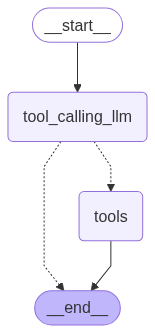

In [101]:
## State Graph 
#creating a toolnode 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##node def
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tool.invoke(state["messages"])]}


##graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#add edges 
builder.add_edge(START,"tool_calling_llm")
# builder.add_edge("tool_calling_llm",tools_condition)
builder.add_conditional_edges(
    "tool_calling_llm",  # from this node
    tools_condition,     # condition function
)
builder.add_edge("tools", END)

#complining the graph 
graph = builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))


In [89]:
response = graph.invoke({"messages":"What is the recent ai news"})

In [90]:
response['messages'][-1].content

'{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://punchng.com/leveraging-ai-to-solve-everyday-challenges/?utm_source=auto-read-also&utm_medium=web", "title": "Leveraging AI to solve everyday challenges - Punch Newspapers", "score": 0.6194488, "published_date": "Tue, 16 Sep 2025 01:15:29 GMT", "content": "AI also powers personalised banking solutions for everyday Nigerians. Mobile banking apps now use AI to analyse individual spending habits, provide budgeting tips, suggest savings plans, and even automate investment strategies. These tools empower users to make smarter financial decisions, manage money more effectively, and build wealth over time.\\n\\nRelated News [...] Beyond individual farmers, AI is transforming agribusiness operations across the country. Supply chain management, traditionally plagued by inefficiencies, is now being streamlined through AI systems that track the movement of crops from farms to markets. Thes

In [91]:
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_5a5526d2-8631-4c0b-9e61-41d0be0f6c0a)
 Call ID: fc_5a5526d2-8631-4c0b-9e61-41d0be0f6c0a
  Args:
    query: AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://punchng.com/leveraging-ai-to-solve-everyday-challenges/?utm_source=auto-read-also&utm_medium=web", "title": "Leveraging AI to solve everyday challenges - Punch Newspapers", "score": 0.6194488, "published_date": "Tue, 16 Sep 2025 01:15:29 GMT", "content": "AI also powers personalised banking solutions for everyday Nigerians. Mobile banking apps now use AI to analyse individual spending h

In [108]:
#fro mulitply invoke
response = graph.invoke({"messages":"what is 2 multiplied by 4"})
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 4
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_d2ab5b43-c970-474d-b394-1b29899f2c84)
 Call ID: fc_d2ab5b43-c970-474d-b394-1b29899f2c84
  Args:
    a: 2
    b: 4
================================= Tool Message =================================
Name: multiply

8


### ReAct Agent Architecture 


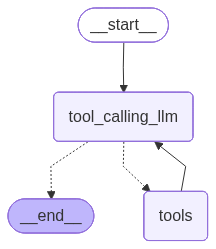

In [125]:
## State Graph 
#creating a toolnode 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

##node def
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tool.invoke(state["messages"])]}


##graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#add edges 
builder.add_edge(START,"tool_calling_llm")
# builder.add_edge("tool_calling_llm",tools_condition)
builder.add_conditional_edges(
    "tool_calling_llm",  # from this node
    tools_condition,     # condition function
)
builder.add_edge("tools","tool_calling_llm")

#complining the graph 
graph = builder.compile()

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [126]:
response = graph.invoke({"messages":"what is 2 multiplied by 4 and then give me latest news"})
for m in response['messages']:
  m.pretty_print()

================================ Human Message =================================

what is 2 multiplied by 4 and then give me latest news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_1166359a-0f3e-4a25-a464-283e469c0167)
 Call ID: fc_1166359a-0f3e-4a25-a464-283e469c0167
  Args:
    query: latest news
    search_depth: advanced
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.democratandchronicle.com/press-release/story/102711/trending-today-launches-new-podcast-to-expand-on-the-award-winning-tv-series/", "title": "‘Trending Today’ Launches New Podcast to Expand on the Award-Winning TV Series - Democrat and Chronicle", "score": 0.5113512, "published_date": "Thu, 11 Sep 2025 18:42:07 GMT", "content": "### Breakthrough 3D Virtual Care Debut

### ADDING MEM in GRAPH


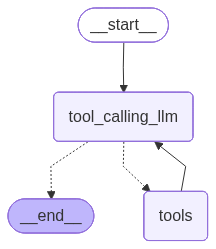

In [ ]:
## State Graph 
#creating a toolnode 
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver  #to remember previous context 

memory = MemorySaver()

##node def
def tool_calling_llm(state:State):
  return {"messages":[llm_with_tool.invoke(state["messages"])]}


##graph 
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

#add edges 
builder.add_edge(START,"tool_calling_llm")
# builder.add_edge("tool_calling_llm",tools_condition)
builder.add_conditional_edges(
    "tool_calling_llm",  # from this node
    tools_condition,     # condition function
)
builder.add_edge("tools","tool_calling_llm")

#complining the graph 
graph = builder.compile(checkpointer=memory)

from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [133]:
config = {"configurable":{"thread_id":"1"}}

response = graph.invoke({"messages":"Hi my name is Chirag"},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Chirag', additional_kwargs={}, response_metadata={}, id='e2b6eea2-0d1c-4048-82f1-58de0aa4c99b'),
  AIMessage(content='Hello Chirag! 👋 How can I help you today?', additional_kwargs={'reasoning_content': 'We need to respond to greeting. Probably ask how can help.'}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 1391, 'total_tokens': 1427, 'completion_time': 0.032212967, 'prompt_time': 0.090895893, 'queue_time': 0.047888878, 'total_time': 0.12310886}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_4c4aa6a4a4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c299e85a-2cf4-448f-b9dc-455e130391bb-0', usage_metadata={'input_tokens': 1391, 'output_tokens': 36, 'total_tokens': 1427})]}

In [136]:
response = graph.invoke({"messages":"What is my name"},config=config)
print(response['messages'][-1].content)


You’re Chirag.
